In [1]:
import bayes3d as b
import bayes3d.transforms_3d as t3d
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax.debug import print as jprint
import physics_priors as p
import importlib
importlib.reload(p)
import time
import PIL.Image
from math import sqrt
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import plotly.graph_objects as go
%matplotlib inline 


In [2]:
def display_video(frames, framerate=30):
    if type(frames[0]) == PIL.Image.Image:
      frames = [np.array(frames[i]) for i in range(len(frames))]
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=True)
    return HTML(anim.to_html5_video())

In [3]:
intrinsics = b.Intrinsics(
    height=360,
    width=480,
    fx=180*sqrt(3), fy=180*sqrt(3),
    cx=240.0, cy=180.0,
    near=0.1, far=10.0
)
# intrinsics = b.Intrinsics(
#     height=300,
#     width=300,
#     fx=200.0, fy=200.0,
#     cx=150.0, cy=150.0,
#     near=0.001, far=6.0
# )

In [4]:
b.setup_renderer(intrinsics)
# b.RENDERER.add_mesh_from_file("assets/cube.obj",mesh_name="cube_0", scaling_factor=0.5)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (480, 384, 1024)


In [5]:
loaded_poses = np.load('scene_npzs/scene_demo.npz')

In [7]:
# Find number of timesteps
N_tsteps = loaded_poses['box'].shape[0]

# load occluder poses into (N,4,4)
occ1_meshscale = loaded_poses['occ1_meshscale']
# occ1_meshscale = [0.0667,0.0667,0.0667]
occ1_pose = loaded_poses['occ1']
occ1_pose[1:3] *= -1
occ1_poses = jnp.tile(jnp.array(occ1_pose), (N_tsteps,1,1))

# occ2_meshscale = loaded_poses['occ2_meshscale']
# occ2_pose = loaded_poses['occ2']
# occ2_pose[1:3] *= -1
# occ2_poses = jnp.tile(jnp.array(occ2_pose), (N_tsteps,1,1))

# get object poses
gt_poses = loaded_poses['box']
gt_poses[:,1:3,:] *= -1 # CV2 convention
gt_poses = jnp.array(gt_poses)

# combine the poses
# total_gt_poses = jnp.stack([gt_poses, occ1_poses, occ2_poses], axis = 1)
total_gt_poses = jnp.stack([gt_poses, occ1_poses], axis = 1)

# cv2 convention of cam pose
world2cam = np.linalg.inv(loaded_poses['cam_pose'])
world2cam[1:3] *= -1
cam_pose = jnp.linalg.inv(jnp.array(world2cam)) 

In [8]:
b.RENDERER.add_mesh_from_file("assets/cube.obj",mesh_name="cube_0", scaling_factor=[0.5,0.5,0.5])
b.RENDERER.add_mesh_from_file("assets/plane.obj",mesh_name="occluder1", scaling_factor=occ1_meshscale)
# b.RENDERER.add_mesh_from_file("assets/plane.obj",mesh_name="occluder2", scaling_factor=[0.04,0.0667,0.0667])

unable to load materials from: cube.mtl
unable to load materials from: plane.mtl


Centering mesh with translation [0.0000000e+00 0.0000000e+00 2.3841858e-07]


In [9]:
# gt_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(gt_poses, jnp.int32(0))
pose_estimate = gt_poses[0]

# gt_images = b.RENDERER.render_multiobject_parallel(total_gt_poses, [0,1,2])

gt_images = b.RENDERER.render_many(total_gt_poses,jnp.array([0,1]))

# gt_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(gt_poses[:,None, ...], jnp.array([0]))

In [10]:
depths = [b.viz.get_depth_image(gt_images[i,:,:,2]) for i in range(gt_images.shape[0])]


In [11]:
display_video(depths)

In [15]:
dx, dy, dz = 0.2, 0.2, 0.2
translation_deltas = b.utils.make_translation_grid_enumeration(-dx, -dy, -dz, dx, dy, dz, 5,5,5)


dx, dy, dz = 2, 2, 2
gridding = [
    b.utils.make_translation_grid_enumeration(
        -dx, -dy, -dz, dx, dy, dz, 5,5,5
    ),
    b.utils.make_translation_grid_enumeration(
        -dx/2.0, -dy/2, -dz/2, dx/2, dy/2, dz/2, 5,5,5
    ),
    b.utils.make_translation_grid_enumeration(
        -dx/10.0, -dy/10, -dz/10, dx/10, dy/10, dz/10, 5,5,5
    ),
]

key = jax.random.PRNGKey(314)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf_zero_mean(key, 0.00001, 800.0))(
    jax.random.split(key, 100)
)

# len_proposals = gridding[0].shape[0]
len_proposals = translation_deltas.shape[0]

occ1_poses_trans = jnp.tile(occ1_pose, (len_proposals, 1, 1))
# occ2_poses_trans = jnp.tile(occ2_pose, (len_proposals, 1, 1))

occ1_poses_rot = jnp.tile(occ1_pose, (rotation_deltas.shape[0], 1, 1))
# occ2_poses_rot = jnp.tile(occ2_pose, (rotation_deltas.shape[0], 1, 1))


In [16]:
def update_pose_estimate(memory, gt_image):

    pose_memory, T = memory
    old_pose_estimate = pose_memory[T,...]
    prev_pose = pose_memory[T-1,...]

    threedp3_weight = 1
    proposals = jnp.einsum("ij,ajk->aik", old_pose_estimate, translation_deltas)
    rendered_images = b.RENDERER.render_many(jnp.stack([proposals, occ1_poses_trans],axis = 1), jnp.array([0,1]))
    threedp3_scores = threedp3_weight * b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.001, 0.1, 10**3, 3)
    unique_best_3dp3_score = jnp.sum(threedp3_scores == threedp3_scores[jnp.argmax(threedp3_scores)]) == 1

    physics_weight = jax.lax.cond(unique_best_3dp3_score, lambda _ : 5000, lambda _ : 10000, None)
    # physics_weight = 0

    physics_estimated_pose = p.physics_prior_v1_jit(old_pose_estimate, prev_pose, jnp.array([1,1,1]), cam_pose, world2cam)

    physics_scores = jax.lax.cond(jnp.greater(T, 1), 
    lambda _ : physics_weight * p.physics_prior_parallel_jit(proposals, physics_estimated_pose), 
    lambda _ : jnp.zeros(threedp3_scores.shape[0]), 
    None)

    scores = threedp3_scores + physics_scores

    pose_estimate = proposals[jnp.argmax(scores)]
    pose_memory = pose_memory.at[T+1,...].set(pose_estimate)

    pose_world = cam_pose @ pose_estimate
    gt_pose_world = cam_pose @ gt_poses[T-1]
    jprint("{}: {}, {}", T, unique_best_3dp3_score, pose_world[:3,3])
    jprint("{}: GT, {}\n", T, gt_pose_world[:3,3])

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_rot]), jnp.array([0,1]))
    # # rendered_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(proposals, jnp.int32(0))
    # weights_new = b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    return (pose_memory, T+1), pose_estimate

In [17]:
importlib.reload(p)
inference_program = jax.jit(lambda p,x: jax.lax.scan(
    update_pose_estimate, 
    (jnp.tile(p, (x.shape[0]+1,1,1)),1),
    x)[1])

start = time.time()
inferred_poses = inference_program(gt_poses[0], gt_images)
end = time.time()
print ("Time elapsed:", end - start)
print ("FPS:", gt_poses.shape[0] / (end - start))

1: True, [-3.2250395   0.          0.52579015]
1: GT, [-3.2250395   0.          0.52579015]

2: True, [-3.1250396  0.         0.6257902]
2: GT, [-3.1255882  0.         0.6228626]

3: True, [-3.0250397   0.          0.72579026]
3: GT, [-3.0267503  0.         0.7166172]

4: True, [-2.9250398  0.         0.8257903]
4: GT, [-2.9285116  0.         0.8070848]

5: True, [-2.8250399   0.          0.92579037]
5: GT, [-2.830858    0.          0.89429456]

6: True, [-2.72504    0.         1.0257903]
6: GT, [-2.7337759   0.          0.97827494]

7: True, [-2.62504    0.         1.0257903]
7: GT, [-2.637252   0.         1.0590532]

8: True, [-2.5250401e+00 -4.7683716e-07  1.1257904e+00]
8: GT, [-2.5412741e+00 -4.7683716e-07  1.1366556e+00]

9: True, [-2.4250402e+00 -4.7683716e-07  1.2257905e+00]
9: GT, [-2.4458292  0.         1.2111073]

10: True, [-2.3250403e+00 -4.7683716e-07  1.3257904e+00]
10: GT, [-2.3509057e+00 -4.7683716e-07  1.2824328e+00]

11: True, [-2.2250404e+00 -4.7683716e-07  1.325790

In [18]:
viz_images = []
max_depth = 10.0

# inferred_poses_with_occ = jnp.stack([inferred_poses, occ1_poses], axis = 1)
occ_image = b.viz.get_depth_image(b.RENDERER.render(occ1_pose[None,...], jnp.array([1]))[:,:,2])

pred_images = b.RENDERER.render_many(inferred_poses[:,None, ...], jnp.array([0]))

pred_with_occ_images = [b.overlay_image(b.viz.get_depth_image(pred_images[i,:,:,2]), 
occ_image, alpha=0.4) for i in range(pred_images.shape[0])]

gt_images = b.RENDERER.render_many(gt_poses[:,None, ...], jnp.array([0]))
gt_with_occ_images = [b.overlay_image(b.viz.get_depth_image(gt_images[i,:,:,2]), 
occ_image, alpha=0.5) for i in range(pred_images.shape[0])]

viz_images = [
    b.viz.multi_panel(
        [g, b.viz.get_depth_image(p[:,:,2]), po],
        labels = ["Ground Truth", "Reconstruction w/o Occluder", "Reconstruction w Occluder"],
        title = "Scene 11A",
        # bottom_text = "3DP3 + Physics Prior v1"
    )
    for (g, p, po) in zip(gt_with_occ_images, pred_images, pred_with_occ_images)
]
display_video(viz_images)

# labels=None, title=None, bottom_text=None, title_fontsize=40, label_fontsize=30,  bottom_fontsize=20, middle_width=10

In [19]:
def make_gif(images, filename, fps = 10):
    duration = int(1000/fps)
    images[0].save(
        fp=filename,
        format="GIF",
        append_images=images,
        save_all=True,
        duration=duration,
        loop=0,
    )

make_gif(viz_images, "scene_gifs/scene_demo.gif", fps=20)

In [ ]:
# pred_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(inferred_poses, jnp.int32(0))

# viz_images = [
#     b.viz.multi_panel(
#         [b.viz.get_depth_image(g[:,:,2]), b.viz.get_depth_image(p[:,:,2])],
#         labels = ["Ground Truth", "Reconstruction"],
#         title = "Scene 7B"
#         # bottom_text = "3DP3 + Physics Prior v1"

#     )
#     for (g, p) in zip(gt_images, pred_images)
# ]
# display_video(viz_images, framerate=20)

# # labels=None, title=None, bottom_text=None, title_fontsize=40, label_fontsize=30,  bottom_fontsize=20, middle_width=10

In [ ]:
# viz_images = []
# max_depth = 10.0

# inferred_poses_with_occ = jnp.stack([inferred_poses, occ_poses])

# pred_images = b.RENDERER.render_multiobject_parallel(inferred_poses[None, ...], jnp.array([0]))
# occ_image = b.viz.get_depth_image(b.RENDERER.render_single_object(occ_poses[0], 1)[:,:,2])

# pred_with_occ_images = [b.overlay_image(b.viz.get_depth_image(pred_images[i,:,:,2]), 
# occ_image, alpha=0.4) for i in range(pred_images.shape[0])]
# # pred_images = b.RENDERER.render_multiobject_parallel(inferred_poses_with_occ, jnp.array([0,1]))

# viz_images = [
#     b.viz.multi_panel(
#         [b.viz.get_depth_image(g[:,:,2]), b.viz.get_depth_image(p[:,:,2]), po],
#         labels = ["Ground Truth", "Reconstruction w/o Occluder", "Reconstruction w Occluder"],
#         title = "Scene 7E",
#         # bottom_text = "3DP3 + Physics Prior v1"
#     )
#     for (g, p, po) in zip(gt_images, pred_images, pred_with_occ_images)
# ]
# display_video(viz_images)

# # labels=None, title=None, bottom_text=None, title_fontsize=40, label_fontsize=30,  bottom_fontsize=20, middle_width=10

In [ ]:
### DUMMY VALUES #########

translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 10, 10, 10)

# MANUALLY SPECIFY THESE
prev_prev_pose = jnp.array([[1., 0., 0., -0.1],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
prev_pose = jnp.array([[1., 0., 0., -0.0],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])

best_pose = jnp.array([[1., 0., 0., 0.1],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])


proposals = jnp.einsum("ij,ajk->aik", prev_pose, translation_deltas)
weights = physics_prior_v1_parallel(proposals, prev_pose, prev_prev_pose, jnp.array([1,1,1]), cam_pose, world2cam)
plot_physics_posterior(proposals, prev_pose, prev_prev_pose,weights, best_pose)

In [ ]:
def plot_physics_posterior(proposals, pp, ppp, weights, best_pose = None):
    xs = np.asarray(proposals[:,0,3])
    ys = np.asarray(proposals[:,1,3])
    zs = np.asarray(proposals[:,2,3])

    prev = np.asarray(pp[:3,3])
    prev_prev = np.asarray(ppp[:3,3])    

    anns = [dict(
        showarrow=False,
        x=prev_prev[0],
        y=prev_prev[1],
        z=prev_prev[2],
        text="T-2",
        xanchor="left",
        xshift=5,
        opacity=0.7,
        font=dict(
            size=9  # Adjust the font size of the annotation
        )
    ),
    dict(
        showarrow=False,
        x=prev[0],
        y=prev[1],
        z=prev[2],
        text="T-1",
        xanchor="left",
        xshift=5,
        opacity=0.7,
        font=dict(
            size=9  # Adjust the font size of the annotation
        )
    )]

    pts = [go.Scatter3d(x=[prev_prev[0]],
                y=[prev_prev[1]],
                z=[prev_prev[2]],
                mode='markers',
                marker=dict(
                color='black',  # Specify the color values for each data point here
                size=2,
                symbol ='x'
                ),
            ),
    go.Scatter3d(x=[prev[0]],
                y=[prev[1]],
                z=[prev[2]],
                mode='markers',
                marker=dict(
                color='black',  # Specify the color values for each data point here
                size=2,
                symbol ='x'
                ),
            )]


    if best_pose != None:
        best = np.asarray(best_pose[:3,3])
        anns.append(dict(
                    showarrow=False,
                    x=best[0],
                    y=best[1],
                    z=best[2],
                    text="T-0 Best",
                    xanchor="left",
                    xshift=5,
                    opacity=0.7,
                    font=dict(
                        size=9  # Adjust the font size of the annotation
                    )
                ))
        pts.append( go.Scatter3d(x=[best[0]],
                    y=[best[1]],
                    z=[best[2]],
                    mode='markers',
                    marker=dict(
                    color='black',  # Specify the color values for each data point here
                    size=2,
                    symbol ='x'
                    ),
                ))

    fig = go.Figure(data=go.Volume(
        x=xs, y=ys, z=zs,
        value=np.asarray(weights),
        isomin=float(jnp.min(weights)),
        isomax=float(jnp.max(weights)),
        opacity=0.1,
        surface_count=25,
        ))
    fig.update_layout(title = 'Physics Posterior (Translation)',
                        scene_xaxis_showticklabels=True,
                    scene_yaxis_showticklabels=True,
                    scene_zaxis_showticklabels=True,
                    scene=dict(
            annotations=anns
        )
    )
    fig.add_traces(pts)

    fig.show()


In [ ]:
ppp = jnp.around(cam_pose @ pose_estimates_over_time[29], 4)
pp = jnp.around(cam_pose @ pose_estimates_over_time[30], 4)
# translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 5, 5, 5)
proposals1 = jnp.einsum("ij,ajk->aik", pp, translation_deltas)
weights1 = physics_prior_v1_parallel(proposals1, pp, ppp, jnp.array([1,1,1]), cam_pose, world2cam)
plot_physics_posterior(proposals1, pp, ppp,weights1)


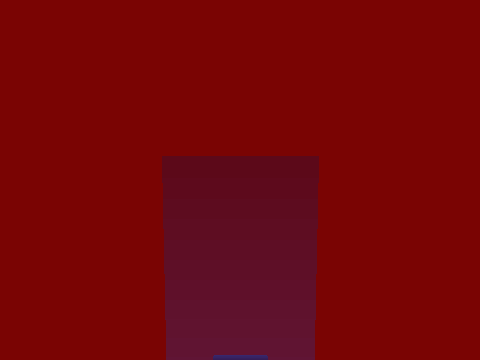

In [69]:
pred_with_occ_images[70]

In [ ]:
gt_poses.shape